This notebook provides an analysis of the relationship between:
- the amount of allocated cubes and the robot type (A or B) 
- the amount of allocated cubes and NVC feature (NVC-robot or non-NVC robot)

Steps:
- descriptive statistics (to understand data better, to find patterns)
- correlation analysis.
- dependent t-test, because you would not expect that allocation of cubes to one robot is not related to the allocation of cubes to the other robot. Here we assume normality and conduct normality test
- If the data is skewed we conduct Wilcoxon paired test, because the data is dependent


In [0]:
# Global constants
invalid_participant = [1,4,18]  # Participants whose data is invalid data
head_switch_participant = 27 # The last participant where the left robot had red face expressions
BEFORE_SWITCH = True
DATA_PATH='/content/PHRIExpData/'

**Imports/Google Auth/G-Drive mounting**
---

In [0]:
import pandas as pd
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as et
import os
import re
from pathlib import Path
from scipy import stats

plt.style.use(['fast'])
plt.style.use(['seaborn-poster'])

In [0]:
# Upload files from shared GDrive folder to Google Colab Workbook

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.preprocessing import StandardScaler

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Reading Questionnaire file
json_import = drive.CreateFile({'id':'1sbqLDqGTV9XjdA7UAFLzXscotaXIof6t'})
json_import.GetContentFile('results-survey128918_26_02_almostevening.csv')
df = pd.read_csv('results-survey128918_26_02_almostevening.csv')

In [0]:
LOCAL_FOLDER_NAME = 'PHRIExpData'
if LOCAL_FOLDER_NAME not in os.listdir():
  os.mkdir(LOCAL_FOLDER_NAME)
if len(os.listdir(LOCAL_FOLDER_NAME)) <=0:
  file_list = drive.ListFile({'q': "'1LS1ueCxeR7UWjfbsJzm3yHmFpkoyvuRY' in parents"}).GetList()

  for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(LOCAL_FOLDER_NAME, f['title'])
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

**Reading Cube Allocation CSV**
---

In [5]:
# Iterate over files and find csv files that have allocation of cubes for each participant
dfs = []

for path in Path(DATA_PATH).rglob('participant_*.csv'): 
      participant_id = int(re.search(r'\d+', path.name).group())
      if participant_id in invalid_participant:
          continue
      #if BEFORE_SWITCH and participant_id > head_switch_participant:
      #  continue
      #elif not BEFORE_SWITCH and participant_id <= head_switch_participant:
      #  continue
      temp = pd.read_csv(path)
      temp["scene"] = temp["scene"].str[-1:]
      temp["scene"] = temp["scene"].astype('int')
      temp["participant"] = participant_id
      temp["NVC_A"] = False
      temp["NVC_B"] = False
      
      if int(participant_id) % 2 == 0:
          nvc = "A"
          temp["NVC_A"] = True
      else:
          nvc = "B"
          temp["NVC_B"] = True

      temp["NVC"] = nvc
      temp["allocation_metric"] = (temp["robot_a"] - temp["robot_b"]) / (temp["robot_a"] + temp["robot_b"])
      dfs.append(temp)


raw_data = pd.concat(dfs, axis=0, ignore_index=True)
raw_data["allocation_metric"].fillna(0.0, inplace=True) # handle 0/0
raw_data.head()

,scene,robot_a,robot_b,participant,NVC_A,NVC_B,NVC,allocation_metric
0,0,2,2,32,True,False,A,0.000000
1,1,3,0,32,True,False,A,1.000000
2,2,1,2,32,True,False,A,-0.333333
3,3,3,4,32,True,False,A,-0.142857
4,4,0,7,32,True,False,A,-1.000000


In [0]:
 # Find the total amount of cubes that participants allocated
cubes_per_participant = raw_data.groupby("participant").sum()
cubes_per_participant = cubes_per_participant.drop(columns=['scene'])
cubes_per_participant['total_cubes'] = cubes_per_participant['robot_a'] + cubes_per_participant['robot_b'] 

## **Descriptive statistics: plots**




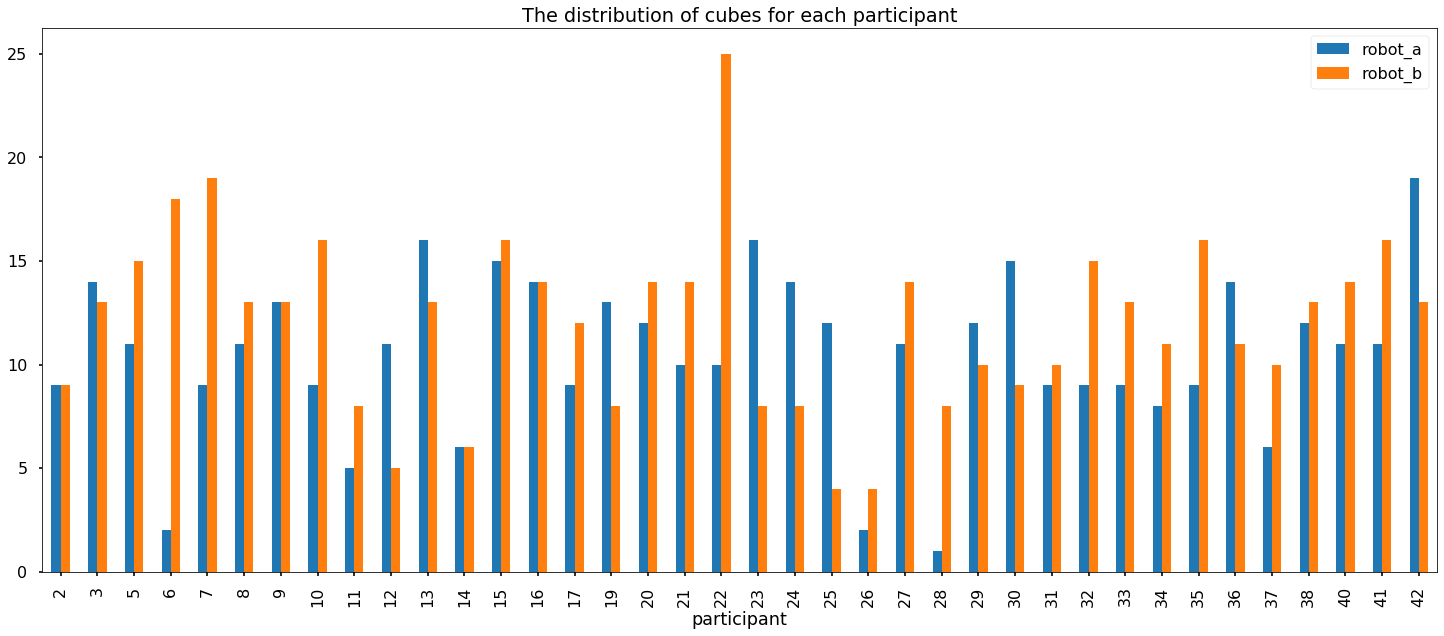

In [7]:
cubes_per_participant[['robot_a', 'robot_b']].plot(kind = 'bar', yticks=range(0, 30, 5), figsize=(25,10), title="The distribution of cubes for each participant")

Box plots for robot A and robot B:

Text(0.5, 0.98, 'Box plots for robot A and robot B')

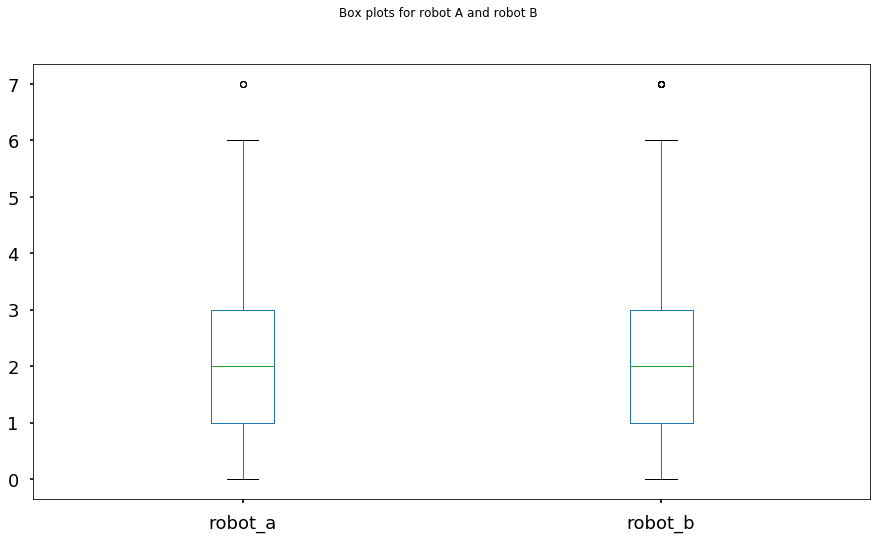

In [8]:
axes = raw_data.boxplot(column=['robot_a', 'robot_b'], figsize=(15,8), fontsize=18, grid=False)
fig = axes.get_figure()
fig.suptitle('Box plots for robot A and robot B')

Boxplots for robot A and robot B grouped by NVC, e.g. the left plot means that 
A is an NVC-robot:

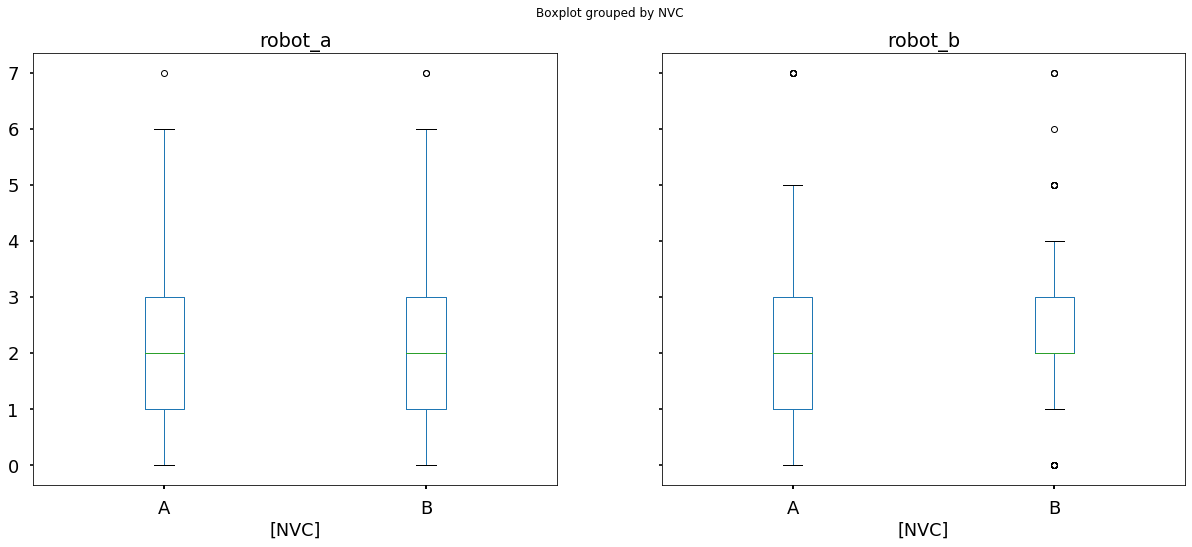

In [9]:
axes = raw_data[['robot_a', 'robot_b', 'NVC']].boxplot(by='NVC', figsize=(20,8), fontsize=18, grid=False)

Boxplots for robot A and robot B grouped by scene:


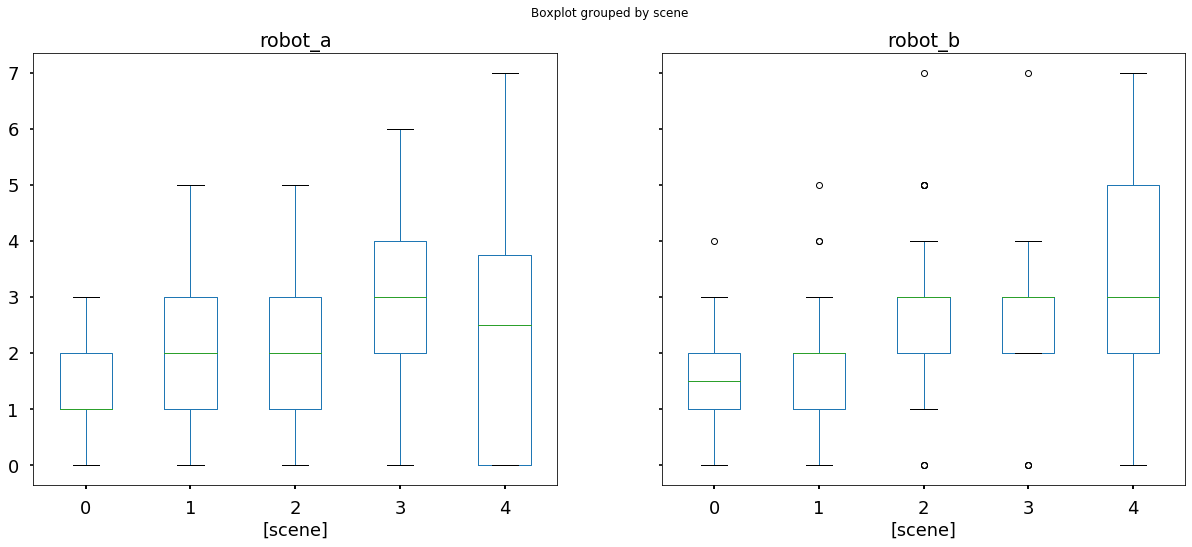

In [10]:
axes = raw_data[['robot_a', 'robot_b', 'scene']].boxplot(by='scene', figsize=(20,8), fontsize=18, grid=False)

Histogram of allocated cubes for robot A and robot B:

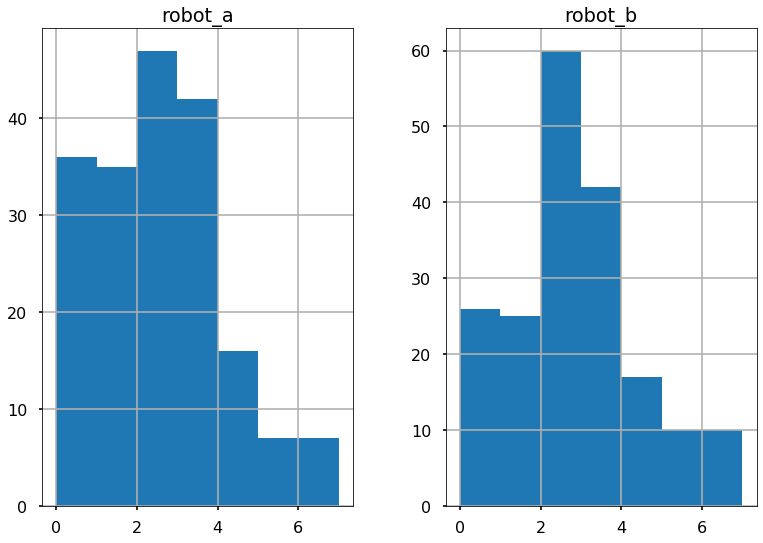

In [11]:
hist = raw_data[['robot_a', 'robot_b']].hist(bins=7)

Histogram of allocated cubes for robot A and robot B grouped by NVC. The plot on the left means taht A is NVC-robot. Plot on the right means that B is non-NVC robot:

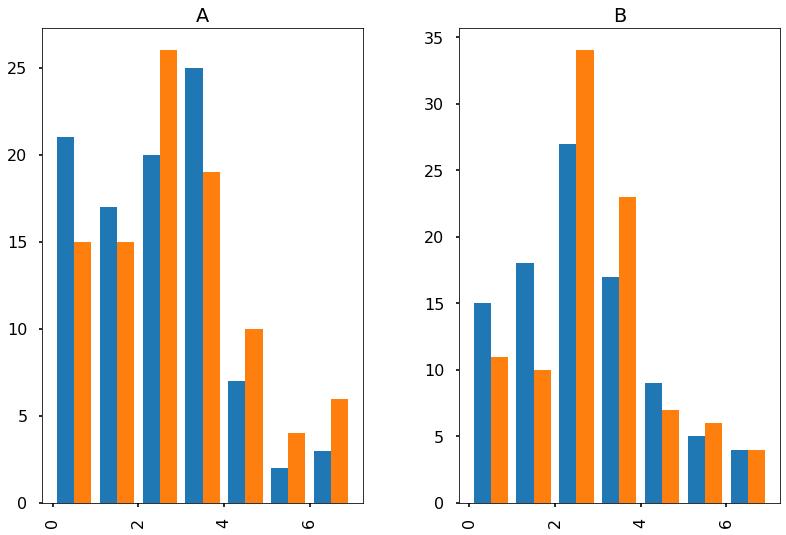

In [12]:
hist = raw_data[['robot_a', 'robot_b', 'NVC']].hist(bins=7, by='NVC')

Density plot considering the number of allocated cubes for robot A and robot B:

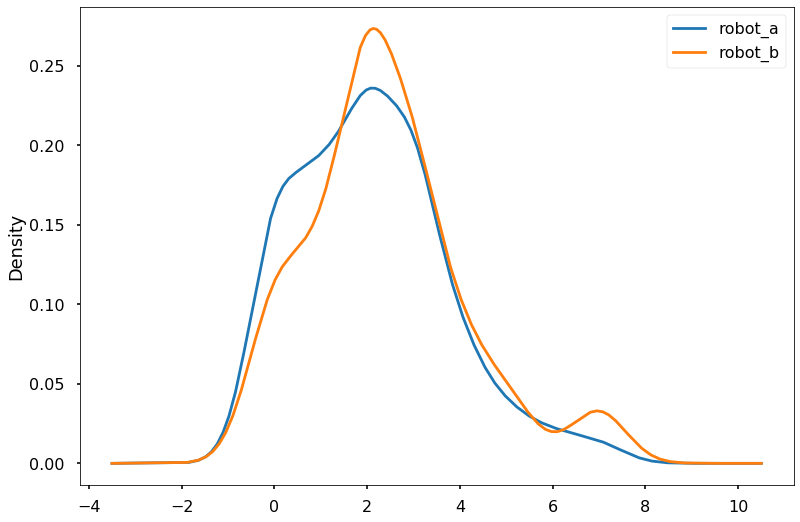

In [13]:
raw_data[['robot_a', 'robot_b']].plot.kde()

The number of allocated cubes of selected participants for each scene (Robot A):

[[<matplotlib.axis.XTick at 0x7fada77e9a90>,

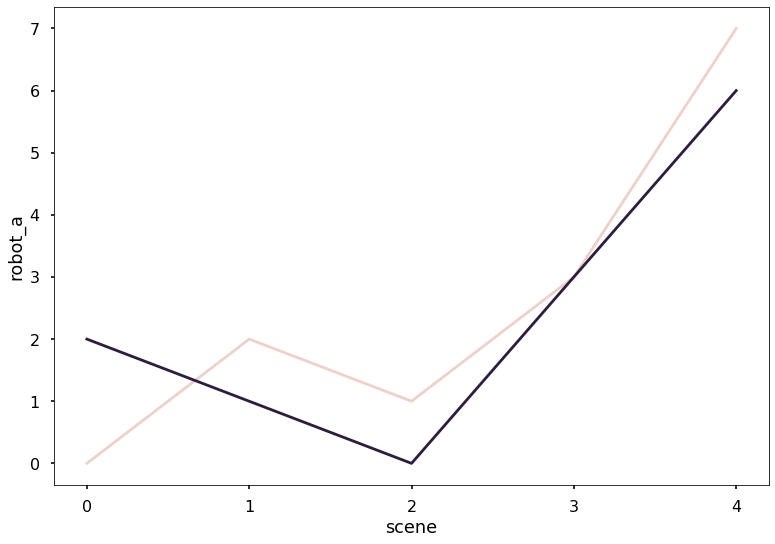

In [14]:
import random
random_participants = random.sample(range(10, 30), 3)
participants_data = raw_data[raw_data['participant'].isin(random_participants)]
ax = sns.lineplot(x="scene", y="robot_a", hue="participant", data=participants_data, legend=False)
ax.set(xticks=[0, 1, 2, 3, 4])

The number of allocated cubes of selected participants for each scene (Robot B):

[[<matplotlib.axis.XTick at 0x7fada7a5dd30>,

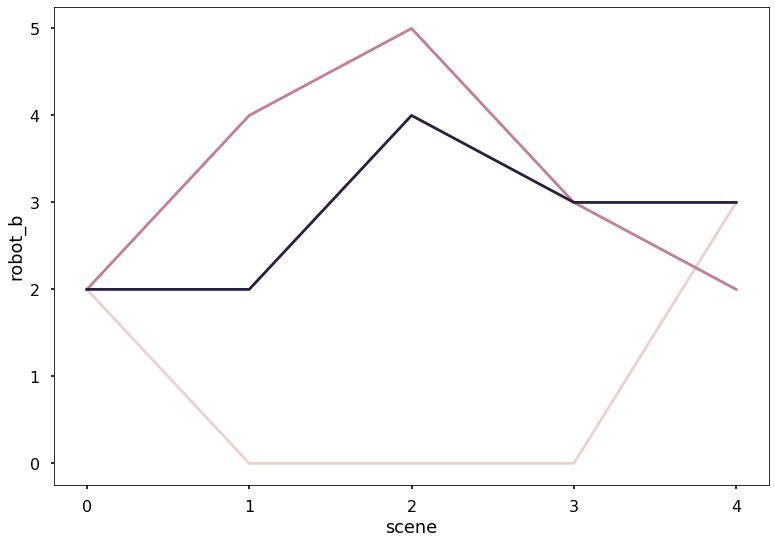

In [15]:
import random
random_participants = random.sample(range(10, 30), 3)
participants_data = raw_data[raw_data['participant'].isin(random_participants)]
ax = sns.lineplot(x="scene", y="robot_b", hue="participant", data=participants_data, legend=False)
ax.set(xticks=[0, 1, 2, 3, 4])

### **Distribution of cubes allocation for each scene**
---

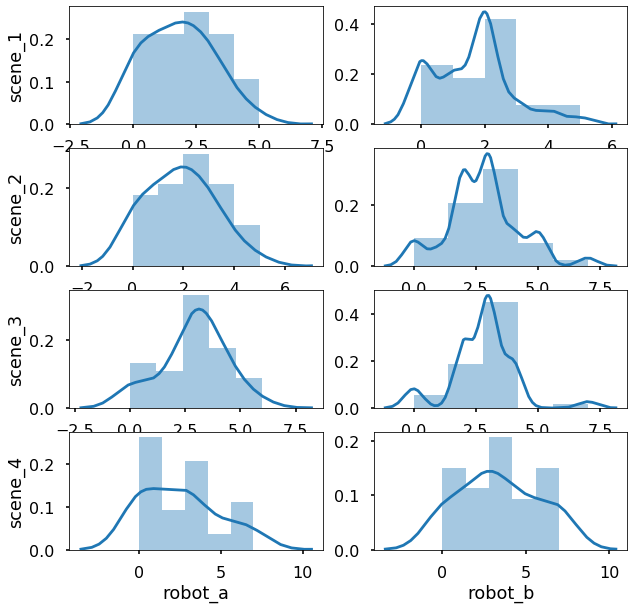

In [16]:
df_scene_1 = raw_data[(raw_data["scene"] == 1)]
df_scene_2 = raw_data[(raw_data["scene"] == 2)]
df_scene_3 = raw_data[(raw_data["scene"] == 3)]
df_scene_4 = raw_data[(raw_data["scene"] == 4)]
# df_scene_1[["robot_a","robot_b"]].hist(bins=5,alpha=0.3)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

ax[0][0].set_ylabel("scene_1")
ax[1][0].set_ylabel("scene_2")
ax[2][0].set_ylabel("scene_3")
ax[3][0].set_ylabel("scene_4")
sns.distplot(df_scene_1["robot_a"], bins=5, ax=ax[0][0])
sns.distplot(df_scene_1["robot_b"], bins=5, ax=ax[0][1])
sns.distplot(df_scene_2["robot_a"], bins=5, ax=ax[1][0])
sns.distplot(df_scene_2["robot_b"], bins=5, ax=ax[1][1])
sns.distplot(df_scene_3["robot_a"], bins=5, ax=ax[2][0])
sns.distplot(df_scene_3["robot_b"], bins=5, ax=ax[2][1])
sns.distplot(df_scene_4["robot_a"], bins=5, ax=ax[3][0])
sns.distplot(df_scene_4["robot_b"], bins=5, ax=ax[3][1])

### Cubes allocation distribution for each scene

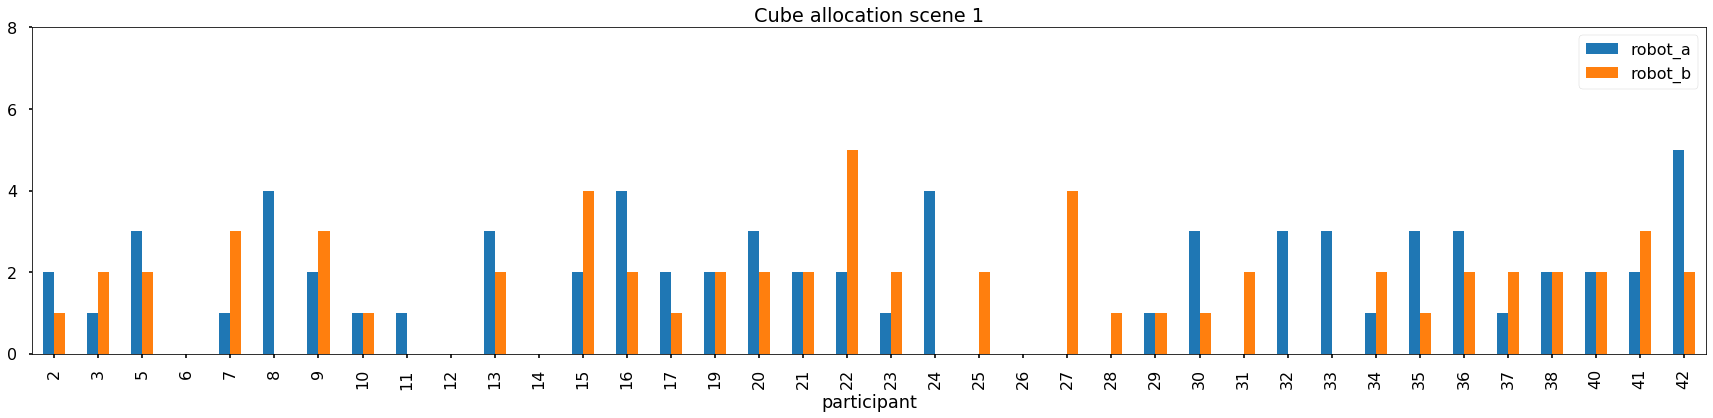

In [17]:
scene = 1
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(30,6), title="Cube allocation scene {}".format(scene))

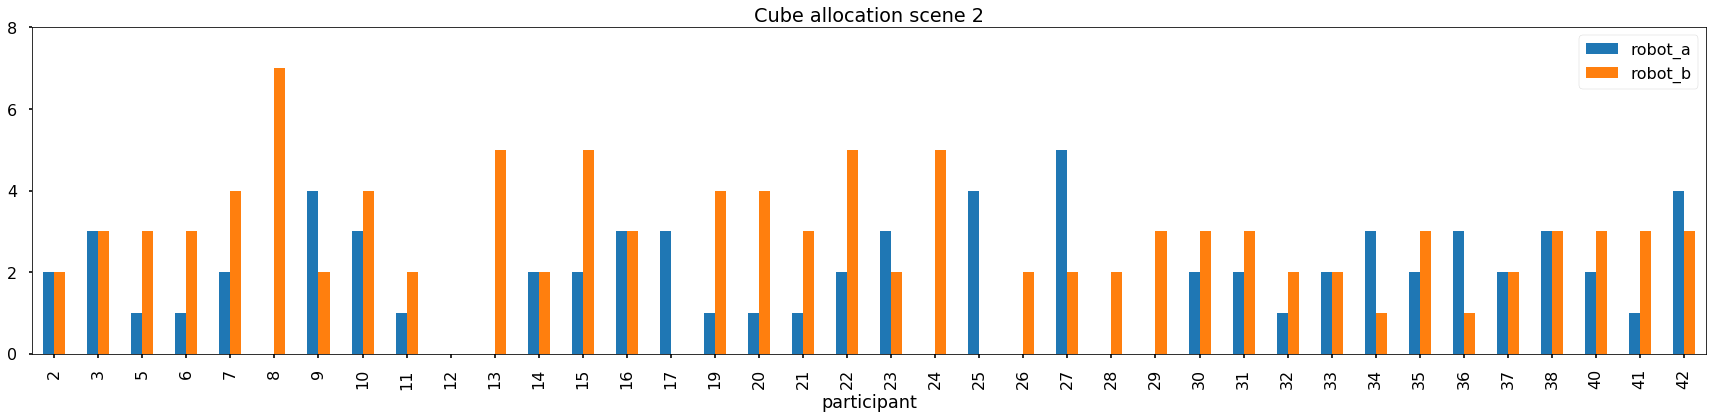

In [18]:
scene = 2
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(30,6), title="Cube allocation scene {}".format(scene))

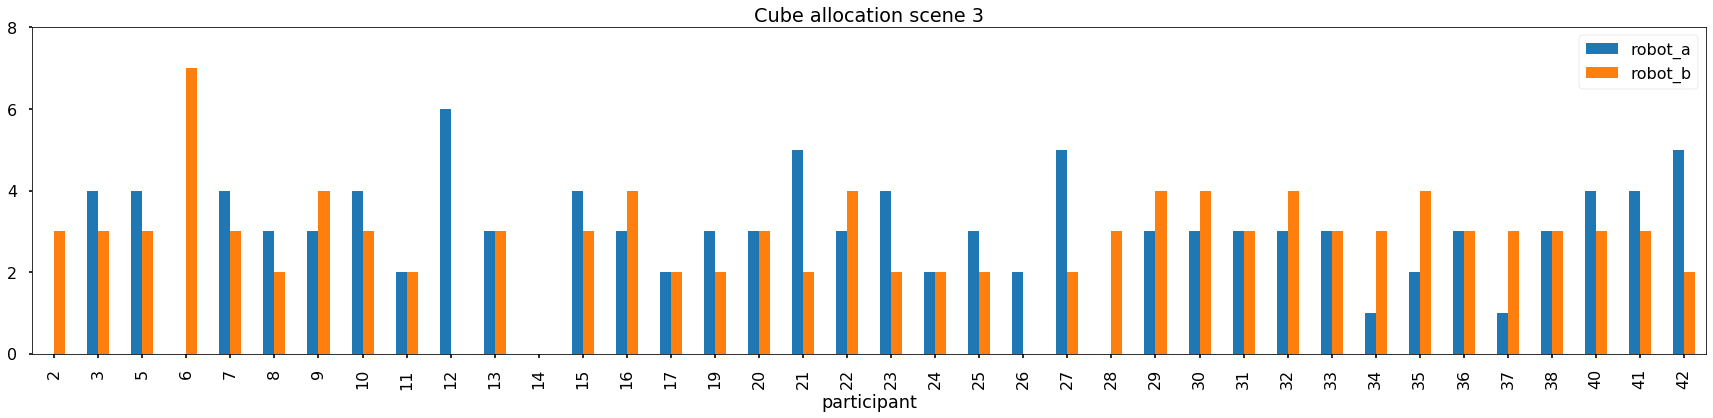

In [19]:
scene = 3
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(30,6), title="Cube allocation scene {}".format(scene))

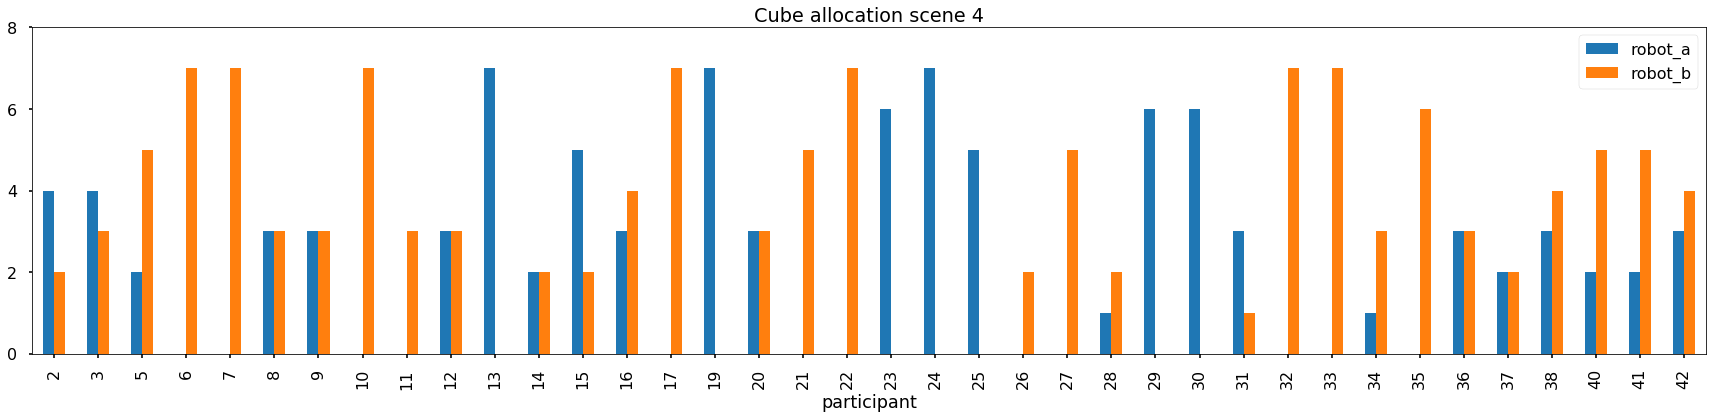

In [20]:
scene = 4
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(30,6), title="Cube allocation scene {}".format(scene))

# **Statistical Test H1: "NVC impacts cubes allocation"**
---

# Trend Checking for alternate cube allocation behavior

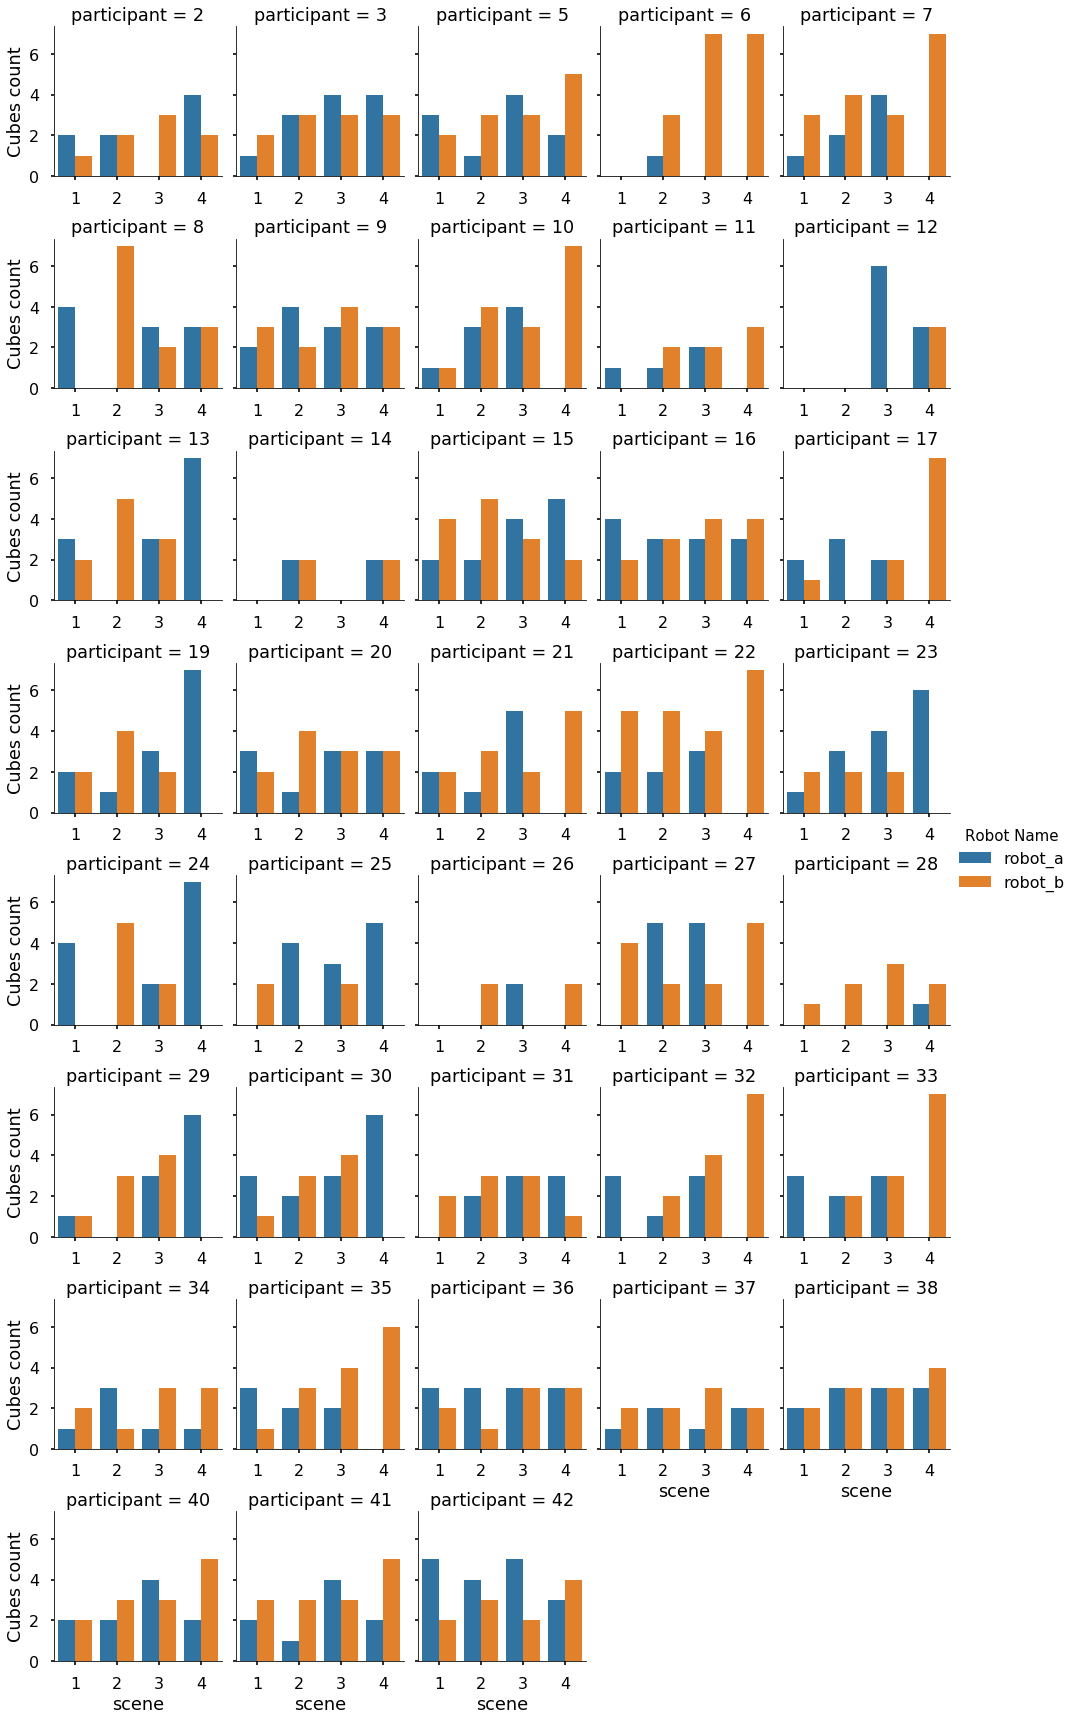

In [81]:
# Only from scene 1 to 4
filtered_data = raw_data[raw_data["scene"] > 0]

fabricated_data = pd.melt(filtered_data, id_vars=['scene', 'participant'], value_vars=['robot_a', 'robot_b'],
        var_name='Robot Name', value_name='Cubes count')
sns.catplot(x='scene', y='Cubes count', hue='Robot Name', col='participant', kind='bar', data=fabricated_data, col_wrap=5, height=3, aspect=0.9, sharex=False)

In [0]:
participant_preferred_B = filtered_data.query('scene==2 and robot_b > robot_a')['participant']
participant_preferred_A = filtered_data.query('scene==2 and robot_a > robot_b')['participant']
participant_preferred_both = filtered_data.query('scene==2 and robot_a == robot_b and robot_a>0')['participant']
participant_preferred_none = filtered_data.query('scene==2 and robot_a == robot_b and robot_a==0')['participant']

def get_allocation_count_in_next_scene(scene_no, prev_scene_allocation):
  preferred_A = filtered_data.query('scene==@scene_no and robot_a > robot_b and participant in @prev_scene_allocation')['participant']
  preferred_B = filtered_data.query('scene==@scene_no and robot_b > robot_a and participant in @prev_scene_allocation')['participant']
  preferred_Both = filtered_data.query('scene==@scene_no and robot_a == robot_b and robot_b>0 and participant in @prev_scene_allocation')['participant']
  preferred_None = filtered_data.query('scene==@scene_no and robot_a == robot_b and robot_b==0 and participant in @prev_scene_allocation')['participant']
  return [preferred_A.count(), preferred_B.count(), preferred_Both.count(), preferred_None.count()]

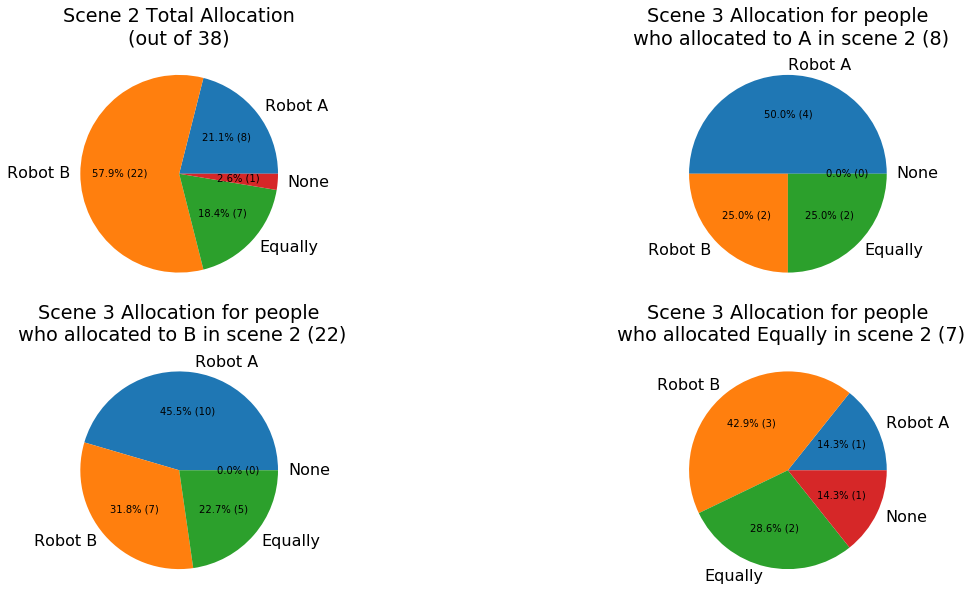

In [23]:
def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct,v=val)
    return autopct

vals = np.array([get_allocation_count_in_next_scene(3, participant_preferred_A),
                 get_allocation_count_in_next_scene(3, participant_preferred_B),
                 get_allocation_count_in_next_scene(3, participant_preferred_both),
                 get_allocation_count_in_next_scene(3, participant_preferred_none)
                 ])
labels = ['Robot A', 'Robot B', 'Equally', 'None']
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0][0].pie(vals.sum(axis=1), radius=1, labels=labels, autopct=make_autopct(vals.sum(axis=1)))
ax[0][0].set(aspect="equal")
ax[0][0].set_title("Scene 2 Total Allocation\n(out of "+str(vals.sum())+")")
ax[0][1].pie(vals[0], radius=1, labels=labels, autopct=make_autopct(vals[0]))
ax[0][1].set(aspect="equal")
ax[0][1].set_title("Scene 3 Allocation for people\n who allocated to A in scene 2 ("+str(vals[0].sum())+")")
ax[1][0].pie(vals[1], radius=1, labels=labels, autopct=make_autopct(vals[1]))
ax[1][0].set(aspect="equal")
ax[1][0].set_title("Scene 3 Allocation for people\n who allocated to B in scene 2 ("+str(vals[1].sum())+")")
ax[1][1].pie(vals[2], radius=1, labels=labels, autopct=make_autopct(vals[2]))
ax[1][1].set(aspect="equal")
ax[1][1].set_title("Scene 3 Allocation for people\n who allocated Equally in scene 2 ("+str(vals[2].sum())+")")
plt.show()

**From this section, following conclusions can be drawn**
1. In scene 2, robot B is preferred(22/38) and out of those 22 people, 15 either switched to robot A or gave them equally in scene 3(5 gave them equally).
2. In scene 2, out of people who preferred robot A(8/35), 4 either switched to robot B or gave them equally in scene 3(2 gave them equally).

## Sub hypothesis: Set of questions asked by participant does not influence cubes allocation

## Sub hypothesis: Speech content does not influence cubes allocation

### Wilcoxon Ranked Sum Test ###
___

***h0: there is no different between content A and content B***

***h1: there is different***

*Scene 1*

In [24]:
temp_a = df_scene_1[df_scene_1["participant"] % 2 == 0]["allocation_metric"]
temp_b = df_scene_1[df_scene_1["participant"] % 2 == 1]["allocation_metric"]
stats.ranksums(temp_a, temp_b)

RanksumsResult(statistic=1.6641005886756872, pvalue=0.0960923294556733)

*Scene 2*

In [25]:
temp_a = df_scene_2[df_scene_2["participant"] % 2 == 0]["allocation_metric"]
temp_b = df_scene_2[df_scene_2["participant"] % 2 == 1]["allocation_metric"]
stats.ranksums(temp_a, temp_b)

RanksumsResult(statistic=-0.39412908679161013, pvalue=0.6934857372922174)

*Scene 3*

In [26]:
temp_a = df_scene_3[df_scene_3["participant"] % 2 == 0]["allocation_metric"]
temp_b = df_scene_3[df_scene_3["participant"] % 2 == 1]["allocation_metric"]
stats.ranksums(temp_a, temp_b)

RanksumsResult(statistic=-1.2115820075445793, pvalue=0.22567242536061782)

*Scene 4*

In [27]:
temp_a = df_scene_4[df_scene_4["participant"] % 2 == 0]["allocation_metric"]
temp_b = df_scene_4[df_scene_4["participant"] % 2 == 1]["allocation_metric"]
stats.ranksums(temp_a, temp_b)

RanksumsResult(statistic=-0.4963107018857313, pvalue=0.619675216883651)

## Sub hypothesis: Robot's face color does not influence cube allocation

## Main Hypothesis NVC cube allocatin > NNVC

***Conclusion***

pvalue scene 1,3,4 > 0.05, accept H0: no difference there is different A and B

scene 2 < 0.05 reject H1: there is difference between robot A and B

*Pair t-test*
---
___

*Scene 1*

In [28]:
stat.ttest_rel(df_scene_1["robot_a"], df_scene_1["robot_b"])

Ttest_relResult(statistic=0.7080043150124204, pvalue=0.4833791108737122)

*Scene 2*

In [29]:
 stat.ttest_rel(df_scene_2["robot_a"], df_scene_2["robot_b"])

Ttest_relResult(statistic=-2.474706529900849, pvalue=0.01804215104070499)

Scene 3

In [30]:
stat.ttest_rel(df_scene_3["robot_a"], df_scene_3["robot_b"])

Ttest_relResult(statistic=0.30673723355889937, pvalue=0.7607630348138692)

Scene 4

In [31]:
stat.ttest_rel(df_scene_4["robot_a"], df_scene_4["robot_b"])

Ttest_relResult(statistic=-1.1919390053326013, pvalue=0.24087432857683932)

***Conclusion***

*p-value >= 0.05, **accept h0:** There is no different between Robot A and Robot B in Scene 1,3,4*

*p-value < 0.05 t < 0, **accept h1:** robot a < robot b in scene 2*

### **Paired t-test to test the difference between NVC and non-NVC robots per scene**

In [32]:
data_nvc_a = raw_data[raw_data['NVC_A'] == True]
data_nvc_a = data_nvc_a[['scene', 'robot_a', 'robot_b']]
data_nvc_a.head()

,scene,robot_a,robot_b
0,0,2,2
1,1,3,0
2,2,1,2
3,3,3,4
4,4,0,7


In [33]:
data_nvc_b = raw_data[raw_data['NVC_B'] == True]
data_nvc_b = data_nvc_b[['scene', 'robot_a', 'robot_b']]
data_nvc_b.head()

,scene,robot_a,robot_b
5,0,2,2
6,1,2,3
7,2,1,3
8,3,4,3
9,4,2,5


In [34]:
scene = 1
res_a_nvc = stats.ttest_rel(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.ttest_rel(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

Ttest_relResult(statistic=2.03565343123193, pvalue=0.05677819840268825)
Ttest_relResult(statistic=-1.0943058062101276, pvalue=0.28824896912820885)


In [35]:
scene = 2
res_a_nvc = stats.ttest_rel(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.ttest_rel(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

Ttest_relResult(statistic=-2.370868057966971, pvalue=0.02911341997692397)
Ttest_relResult(statistic=-1.1541070145475025, pvalue=0.26355010752621977)


In [36]:
scene = 3
res_a_nvc = stats.ttest_rel(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.ttest_rel(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

Ttest_relResult(statistic=-0.43409931012992453, pvalue=0.6693749682459404)
Ttest_relResult(statistic=1.4863010829205867, pvalue=0.1545053890947903)


In [37]:
scene = 4
res_a_nvc = stats.ttest_rel(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.ttest_rel(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

Ttest_relResult(statistic=-1.406904916225318, pvalue=0.17648762805284146)
Ttest_relResult(statistic=-0.4063482654045443, pvalue=0.6892771352673559)


## Conclusion: when the robot A is an NVC-robot in scene 2 there is a difference between expected values of A and B. B is preferred.

# **Correlation of cubes allocation between 2 robots**

In [38]:
raw_data[["scene","robot_a","robot_b"]].corr()

,scene,robot_a,robot_b
scene,1.000000,0.295799,0.422434
robot_a,0.295799,1.000000,-0.250168
robot_b,0.422434,-0.250168,1.000000


# Linear regression

In [0]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [40]:
data = raw_data[["robot_a"]]
num_attrs = ["robot_a"]
cat_attrs = ["scene", "NVC"]

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
])

cat_encoder = OneHotEncoder(sparse=False)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attrs),
        ("cat", cat_encoder, cat_attrs),
])

data_prepared = full_pipeline.fit_transform(raw_data)

reg = LinearRegression().fit(data_prepared, raw_data["robot_b"])

predicted = reg.predict(data_prepared)
score = r2_score(raw_data["robot_b"], predicted, multioutput='raw_values')

print(f'linear regression coef: {reg.coef_}')
print(f'r square score: {score}')

linear regression coef: [-0.69581834 -1.2439622  -0.92902797  0.27810196  0.72503046  1.16985775
 -0.07970971  0.07970971]
r square score: [0.34767581]


In [41]:
data = raw_data[["robot_b"]]
num_attrs = ["robot_b"]
cat_attrs = ["scene", "NVC"]

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
])

cat_encoder = OneHotEncoder(sparse=False)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attrs),
        ("cat", cat_encoder, cat_attrs),
])

data_prepared = full_pipeline.fit_transform(raw_data)

reg = LinearRegression().fit(data_prepared, raw_data["robot_a"])

predicted = reg.predict(data_prepared)
score = r2_score(raw_data["robot_a"], predicted, multioutput='raw_values')

print(f'linear regression coef: {reg.coef_}')
print(f'r square score: {score}')

linear regression coef: [-0.72562118 -1.10925306 -0.63146028 -0.0681673   0.95814849  0.85073215
 -0.12414395  0.12414395]
r square score: [0.28361816]


# Relative cube allocation

In [42]:
df_by_ps = raw_data.groupby(["participant", "scene"]).sum()[["robot_a", "robot_b"]].reset_index() # df group by participant and scene
df_by_ps.head(10)

,participant,scene,robot_a,robot_b
0,2,0,1,1
1,2,1,2,1
2,2,2,2,2
3,2,3,0,3
4,2,4,4,2
5,3,0,2,2
6,3,1,1,2
7,3,2,3,3
8,3,3,4,3
9,3,4,4,3


([<matplotlib.axis.XTick at 0x7fad9fca3198>,
 <a list of 4 Text xticklabel objects>)

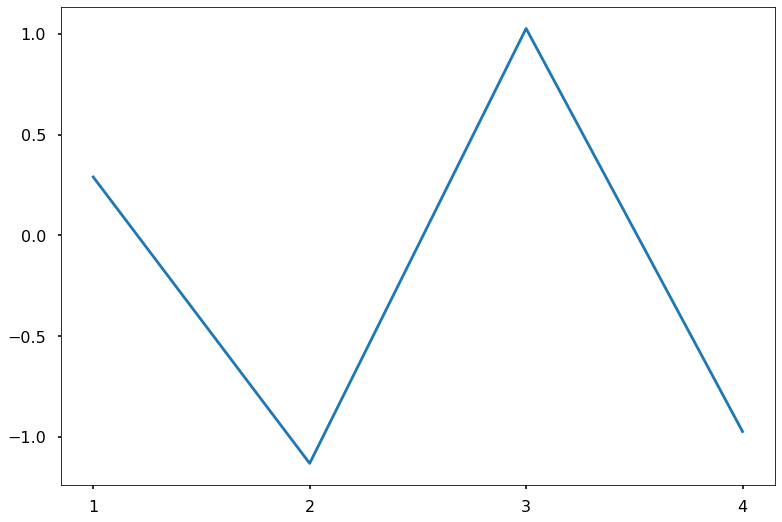

In [43]:
participant_relative_cubes = []
for participant_id in df_by_ps["participant"].unique():
    df_participant = df_by_ps[df_by_ps["participant"] == participant_id]
    count_diff_a = df_participant["robot_a"].diff()
    count_diff_b = df_participant["robot_b"].diff()
    participant_relative_cubes.append(count_diff_a - count_diff_b)


relative_cubes_data = []
scenes = np.arange(1,5)
participant_relative_cubes = np.array(participant_relative_cubes)

temp = []
for scene in scenes:
  mean_relative_cubes = participant_relative_cubes[:, scene].mean()
  temp.append(mean_relative_cubes)

mean_relative_cubes = np.array(temp)
plt.plot(scenes, mean_relative_cubes)
plt.xticks(np.arange(1, 5, 1))


## Predicting robot A cubes based on scene, NVC (OneHotEncoded) and cubes B 

In [44]:
data = raw_data[["robot_a"]]
num_attrs = ["robot_a"]
cat_attrs = ["scene", "NVC"]

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
])

cat_encoder = OneHotEncoder(sparse=False)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attrs),
        ("cat", cat_encoder, cat_attrs),
])

data_prepared = full_pipeline.fit_transform(raw_data)

reg = LinearRegression().fit(data_prepared, raw_data["robot_b"])
predicted = reg.predict(data_prepared)
score = r2_score(raw_data["robot_b"], predicted, multioutput='raw_values')
print("R square score: {}".format(score))
print("reg coef: {}".format(reg.coef_))

R square score: [0.34767581]
reg coef: [-0.69581834 -1.2439622  -0.92902797  0.27810196  0.72503046  1.16985775
 -0.07970971  0.07970971]


## Predicting robot B cubes based on scene, NVC (OneHotEncoded) and cubes A 

In [45]:
data = raw_data[["robot_b"]]
num_attrs = ["robot_a"]
cat_attrs = ["scene", "NVC"]

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
])

cat_encoder = OneHotEncoder(sparse=False)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attrs),
        ("cat", cat_encoder, cat_attrs),
])

data_prepared = full_pipeline.fit_transform(raw_data)

reg = LinearRegression().fit(data_prepared, raw_data["robot_a"])
predicted = reg.predict(data_prepared)
score = r2_score(raw_data["robot_b"], predicted, multioutput='raw_values')
print("R square score: {}".format(score))
print("reg coef: {}".format(reg.coef_))

R square score: [-1.41087501]
reg coef: [ 1.59786041e+00 -7.29347078e-17 -6.35191389e-17 -4.98731694e-17
  1.39906069e-16  4.64209473e-17 -5.85044262e-17  5.85044262e-17]


# **Calculating the significance of allocated cubes as:**
---
*the number of allocated cubes to one robot divided by the sum of allocated cubes to both robots*

In [46]:
approach1 = raw_data.copy()
approach1["sum_cubes_a_and_b"] = approach1["robot_a"] + approach1["robot_b"]
approach1["significance_A"] = approach1["robot_a"] / approach1["sum_cubes_a_and_b"]
approach1["significance_B"] = approach1["robot_b"] / approach1["sum_cubes_a_and_b"]
approach1.head()

,scene,robot_a,robot_b,participant,NVC_A,NVC_B,NVC,allocation_metric,sum_cubes_a_and_b,significance_A,significance_B
0,0,2,2,32,True,False,A,0.000000,4,0.500000,0.500000
1,1,3,0,32,True,False,A,1.000000,3,1.000000,0.000000
2,2,1,2,32,True,False,A,-0.333333,3,0.333333,0.666667
3,3,3,4,32,True,False,A,-0.142857,7,0.428571,0.571429
4,4,0,7,32,True,False,A,-1.000000,7,0.000000,1.000000


In [47]:
data_nvc_a = raw_data[raw_data['NVC'] == 'A']
data_nvc_a = data_nvc_a[['scene', 'robot_a', 'robot_b']]
data_nvc_a.head()

,scene,robot_a,robot_b
0,0,2,2
1,1,3,0
2,2,1,2
3,3,3,4
4,4,0,7


*Significance of robots in each scene*
---
___

In [48]:
approach1_plot_data = approach1.groupby(['scene']).mean()
approach1_plot_data = approach1_plot_data[['significance_A', 'significance_B']]
approach1_plot_data

,significance_A,significance_B
scene,,
0,0.478291,0.521709
1,0.518137,0.481863
2,0.393308,0.606692
3,0.500386,0.499614
4,0.419173,0.580827


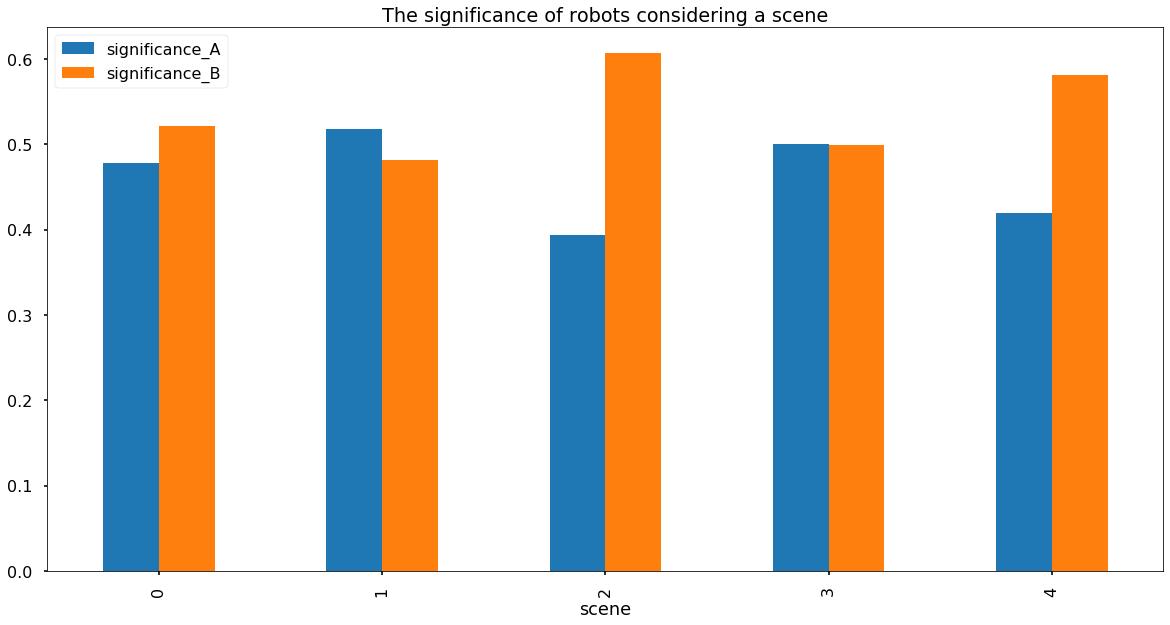

In [49]:
 approach1_plot_data.plot(kind='bar', figsize=(20,10), title='The significance of robots considering a scene')

*Significance of robots with & without NVC in each scene*
---
___

In [50]:
approach1_plot_data = approach1.groupby(['scene', 'NVC']).mean()
approach1_plot_data = approach1_plot_data[['significance_A', 'significance_B']]
approach1_plot_data

significance_A  significance_B
scene NVC                                
0     A          0.495798        0.504202
      B          0.460784        0.539216
1     A          0.607778        0.392222
      B          0.447368        0.552632
2     A          0.353836        0.646164
      B          0.430702        0.569298
3     A          0.467857        0.532143
      B          0.531203        0.468797
4     A          0.385338        0.614662
      B          0.453008        0.546992

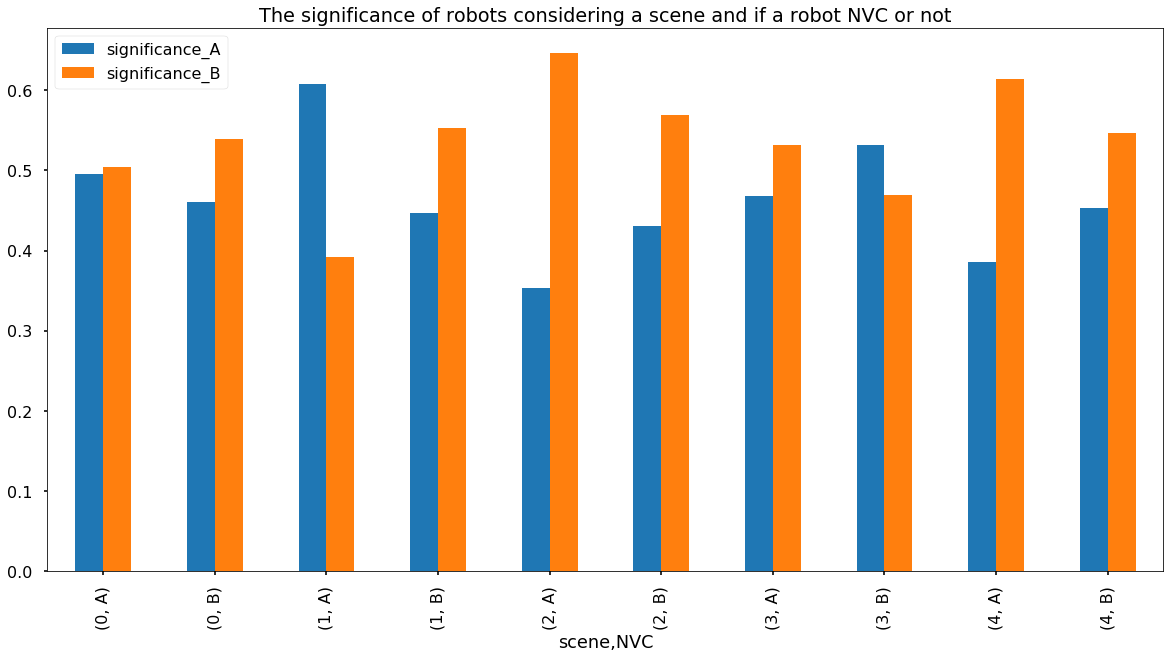

In [51]:
 approach1_plot_data.plot(kind='bar', figsize=(20,10), title='The significance of robots considering a scene and if a robot NVC or not')

In [0]:
def get_significance(row):
   if row['NVC'] == 'A' :
      return row['significance_A']
   if row['NVC'] == 'B' :
      return row['significance_B']
   return 0.0
approach1['significance'] = approach1.apply(lambda row: get_significance(row), axis=1)

In [53]:
data_corr = approach1[approach1['scene']==2]
data_corr = data_corr[['NVC','significance']]
data_corr.NVC = pd.Categorical(data_corr.NVC)
data_corr['NVC_encoded'] = data_corr.NVC.cat.codes
data_corr.corr()

,significance,NVC_encoded
significance,1.000000,0.390266
NVC_encoded,0.390266,1.000000


# **Correlation between personality type and allocated cubes**

In [54]:
personality_data = pd.read_csv(DATA_PATH + 'results-survey128918.csv')
personality_data = personality_data.iloc[:,6 : 30]
personality_data = personality_data.drop(personality_data.columns[[1,2,3,4,5,6,7,8]], axis=1)
personality_data.tail()

,What is your participant number?,Do you agree or disagree with the following statements? [Do you worry a lot?],Do you agree or disagree with the following statements? [Do you get nervous easily?],Do you agree or disagree with the following statements? [Do you remain calm in tense situations?],Do you agree or disagree with the following statements? [Are you talkative?],"Do you agree or disagree with the following statements? [Are you outgoing, sociable?]",Do you agree or disagree with the following statements? [Are you reserved?],Do you agree or disagree with the following statements? [Are you original? / Do you come up with new ideas?],"Do you agree or disagree with the following statements? [Do you value artistic, aesthetic experiences?]",Do you agree or disagree with the following statements? [Do you have an active imagination?],Do you agree or disagree with the following statements? [Are you sometimes rude to others?],Do you agree or disagree with the following statements? [Do you have a forgiving nature?],Do you agree or disagree with the following statements? [Are you considerate and kind to almost everyone?],Do you agree or disagree with the following statements? [Do you do a thorough job?],Do you agree or disagree with the following statements? [Do you tend to be lazy?],Do you agree or disagree with the following statements? [Do you do things efficiently?]
37,38,A5,A4,A4,A3,A3,A3,A4,A5,A5,A4,A3,A4,A5,A2,A4
38,39,A3,A4,A6,A2,A4,A5,A5,A6,A5,A2,A7,A6,A6,A4,A6
39,40,A2,A4,A3,A6,A5,A5,A7,A4,A5,A5,A7,A7,A2,A6,A6
40,41,A1,A2,A6,A6,A6,A2,A7,A5,A7,A3,A5,A6,A6,A5,A6
41,42,A2,A4,A6,A5,A5,A5,A6,A4,A6,A1,A7,A6,A5,A6,A3


In [55]:
personality_data.columns = ['participant', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15']
cols_to_check = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15']
personality_data[cols_to_check] = personality_data[cols_to_check].replace({'A':''}, regex=True)
personality_data = personality_data.apply(pd.to_numeric)
personality_data['Q3'] = 8 - personality_data['Q3']
personality_data['Q6'] = 8 - personality_data['Q6']
personality_data['Q10'] = 8 - personality_data['Q10']
personality_data['Q14'] = 8 - personality_data['Q14']

neuroticism_cols_to_check = ['Q1', 'Q2', 'Q3']
extraversion_cols_to_check = ['Q4', 'Q5', 'Q6']
openness_cols_to_check = ['Q7', 'Q8', 'Q9']
agreeableness_cols_to_check = ['Q10', 'Q11', 'Q12']
conscientiousness_cols_to_check = ['Q13', 'Q14', 'Q15']

# See https://www.oecd.org/skills/piaac/Annex-A-Measures-of-the-big-five-dimensions.pdf
personality_data['neuroticism'] = personality_data[neuroticism_cols_to_check].sum(axis=1)
personality_data['extraversion'] = personality_data[extraversion_cols_to_check].sum(axis=1)
personality_data['openness'] = personality_data[openness_cols_to_check].sum(axis=1)
personality_data['agreeableness'] = personality_data[agreeableness_cols_to_check].sum(axis=1)
personality_data['conscientiousness'] = personality_data[conscientiousness_cols_to_check].sum(axis=1)

pd.set_option('display.max_columns', None)
personality_data = personality_data.set_index("participant")
personality_data.tail()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,neuroticism,extraversion,openness,agreeableness,conscientiousness
participant,,,,,,,,,,,,,,,,,,,,
38,5,4,4,3,3,5,4,5,5,4,3,4,5,6,4,13,11,14,11,15
39,3,4,2,2,4,3,5,6,5,6,7,6,6,4,6,9,9,16,19,16
40,2,4,5,6,5,3,7,4,5,3,7,7,2,2,6,11,14,16,17,10
41,1,2,2,6,6,6,7,5,7,5,5,6,6,3,6,5,18,19,16,15
42,2,4,2,5,5,3,6,4,6,7,7,6,5,2,3,8,13,16,20,10


In [56]:
cubes_data = raw_data.groupby(['participant']).sum()
cubes_data = cubes_data[["robot_a", "robot_b"]]
merged_data = pd.merge(personality_data, cubes_data, how='inner', on='participant')
merged_data = merged_data[["neuroticism", "extraversion", "openness", "agreeableness", "conscientiousness", "robot_a", "robot_b"]]
merged_data = merged_data.reset_index()
merged_data

,participant,neuroticism,extraversion,openness,agreeableness,conscientiousness,robot_a,robot_b
0,2,10,17,18,13,13,9,9
1,3,6,19,19,17,19,14,13
2,5,15,8,17,13,12,11,15
3,6,5,15,8,18,13,2,18
4,7,9,16,12,16,13,9,19
5,8,11,11,21,20,17,11,13
6,9,15,18,20,16,19,13,13
7,10,14,9,15,13,10,9,16
8,11,7,15,18,18,13,5,8
9,12,12,9,19,13,10,11,5


Correlation between personality types and allocation of cubes for both robots when robot A is an NVC robot

In [57]:
nvc_a = merged_data[merged_data["participant"] % 2 == 0]
nvc_a[["neuroticism", "extraversion", "openness", "agreeableness", "conscientiousness", "robot_a", "robot_b"]].corr()

,neuroticism,extraversion,openness,agreeableness,conscientiousness,robot_a,robot_b
neuroticism,1.000000,-0.058798,0.511411,-0.131234,-0.123673,0.023563,0.159091
extraversion,-0.058798,1.000000,-0.166370,-0.245124,0.420416,-0.221226,0.259131
openness,0.511411,-0.166370,1.000000,0.246481,0.034704,0.497522,-0.180568
agreeableness,-0.131234,-0.245124,0.246481,1.000000,-0.195020,0.248402,0.346316
conscientiousness,-0.123673,0.420416,0.034704,-0.195020,1.000000,-0.030058,0.051054
robot_a,0.023563,-0.221226,0.497522,0.248402,-0.030058,1.000000,0.137628
robot_b,0.159091,0.259131,-0.180568,0.346316,0.051054,0.137628,1.000000


Correlation between personality types and allocation of cubes for both robots when robot B is an NVC robot



In [58]:
nvc_b = merged_data[merged_data["participant"] % 2 == 1]
nvc_b[["neuroticism", "extraversion", "openness", "agreeableness", "conscientiousness", "robot_a", "robot_b"]].corr()

,neuroticism,extraversion,openness,agreeableness,conscientiousness,robot_a,robot_b
neuroticism,1.000000,-0.498189,0.055245,0.322900,-0.186132,-0.314606,-0.211273
extraversion,-0.498189,1.000000,0.477111,0.175393,0.130786,0.336436,0.286104
openness,0.055245,0.477111,1.000000,0.337457,0.247778,0.153181,0.053501
agreeableness,0.322900,0.175393,0.337457,1.000000,-0.117031,-0.241368,-0.062945
conscientiousness,-0.186132,0.130786,0.247778,-0.117031,1.000000,0.311275,0.069846
robot_a,-0.314606,0.336436,0.153181,-0.241368,0.311275,1.000000,-0.001049
robot_b,-0.211273,0.286104,0.053501,-0.062945,0.069846,-0.001049,1.000000


In [59]:
data_nvc_a = raw_data[raw_data['NVC_A'] == True]
data_nvc_a = data_nvc_a[['participant', 'scene', 'robot_a', 'robot_b']]
data_nvc_a.head()

data_nvc_b = raw_data[raw_data['NVC_B'] == True]
data_nvc_b = data_nvc_a[['participant', 'scene', 'robot_a', 'robot_b']]
data_nvc_b.head()

assumed_personality =  pd.DataFrame({"personality" : merged_data[["neuroticism", "extraversion", "openness", "agreeableness", "conscientiousness"]].idxmax(axis=1)})
personality_type = pd.concat([merged_data[["participant"]], assumed_personality], axis=1)
personality_type.head()

,participant,personality
0,2,openness
1,3,extraversion
2,5,openness
3,6,agreeableness
4,7,extraversion


In [60]:
scene = 2
res_a_nvc = stats.wilcoxon(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.wilcoxon(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

WilcoxonResult(statistic=19.0, pvalue=0.03362195195318278)
WilcoxonResult(statistic=19.0, pvalue=0.03362195195318278)


# **Questtionnaire Evaluation**
---

# Data Segments Preparation

In [0]:
df = df.drop(columns=['Response ID', 'Date submitted', 'Last page', 'Start language'])
basics = df.loc[ : , ['What is your sex?','How old are you?']]
robot_interaction  = df.loc[ : , [
                      'How familiar are you with computers?', 
                      'Have you ever interacted with a robot before? [Never]',
                      'Have you ever interacted with a robot before? [In an entertainment setting (i.e. drones)]',
                      'Have you ever interacted with a robot before? [In a commercial/utility setting (i.e. vacuums, industry)]',
                      'Have you ever interacted with a robot before? [At work (i.e. robotics research)]',
                      'Do you like robots?'
                      ]
                  ]
tipi = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [Do you worry a lot?]',
                      'Do you agree or disagree with the following statements? [Do you get nervous easily?]',
                      'Do you agree or disagree with the following statements? [Do you remain calm in tense situations?]',
                      'Do you agree or disagree with the following statements? [Are you talkative?]',
                      'Do you agree or disagree with the following statements? [Are you outgoing, sociable?]',
                      'Do you agree or disagree with the following statements? [Are you reserved?]',
                      'Do you agree or disagree with the following statements? [Are you original? / Do you come up with new ideas?]',
                      'Do you agree or disagree with the following statements? [Do you value artistic, aesthetic experiences?]',
                      'Do you agree or disagree with the following statements? [Do you have an active imagination?]',
                      'Do you agree or disagree with the following statements? [Are you sometimes rude to others?]',
                      'Do you agree or disagree with the following statements? [Do you have a forgiving nature?]',
                      'Do you agree or disagree with the following statements? [Are you considerate and kind to almost everyone?]',
                      'Do you agree or disagree with the following statements? [Do you do a thorough job?]',
                      'Do you agree or disagree with the following statements? [Do you tend to be lazy?]',
                      'Do you agree or disagree with the following statements? [Do you do things efficiently?]',
                      ]
                ]
risk_propensity = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [Safety first]', 
                      'Do you agree or disagree with the following statements? [I do not take risks with my health]',
                      'Do you agree or disagree with the following statements? [I prefer to avoid risks]',
                      'Do you agree or disagree with the following statements? [I take risks regularly]',
                      'Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]',
                      ]
                  ]
trust_propensity = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [One should be very cautious with strangers.]',
                      'Do you agree or disagree with the following statements? [Most experts tell the truth about the limits of their knowledge.]',
                      'Do you agree or disagree with the following statements? [Most people can be counted on to do what they say they will do.]',
                      'Do you agree or disagree with the following statements? [Most people answer public opinion polls honestly.]',
                      ]
                  ]
# post questionaire
godspeed = df.iloc[:,36:111]
openQ = df.iloc[:,111:113]

# Data Preprocessing

In [62]:
# risk propensity
# paper says 1-4 are inverted, but 1-3 and 5 makes more sense...
inverted_keys = [
                   "Do you agree or disagree with the following statements? [Safety first]",
                   "Do you agree or disagree with the following statements? [I do not take risks with my health]",
                   "Do you agree or disagree with the following statements? [I prefer to avoid risks]",
                   "Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]"
]
for key, values in risk_propensity.items():
  print(key)
  if key not in inverted_keys:
    # normal scale
    converted_values = [int(value[1:]) for value in values]
  else:
    # inverted scales
    converted_values = [8-int(value[1:]) for value in values]
  print(converted_values)
  risk_propensity[key] = converted_values
risk_propensity_scores = np.sum(risk_propensity.values, axis=1) / 5.0

Do you agree or disagree with the following statements? [Safety first]
[3, 4, 3, 1, 5, 3, 1, 2, 2, 4, 3, 6]
Do you agree or disagree with the following statements? [I do not take risks with my health]
[5, 4, 1, 1, 4, 2, 2, 1, 3, 4, 3, 5]
Do you agree or disagree with the following statements? [I prefer to avoid risks]
[5, 4, 2, 1, 5, 5, 4, 6, 2, 3, 6, 4]
Do you agree or disagree with the following statements? [I take risks regularly]
[3, 4, 3, 3, 5, 3, 4, 7, 3, 3, 5, 2]
Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]
[4, 3, 4, 1, 6, 3, 4, 3, 3, 3, 4, 1]


In [63]:
rps_mean = np.mean(risk_propensity_scores)
rps_std = np.std(risk_propensity_scores)
print("rps mean {} (scaled: {})".format(rps_mean, rps_mean / 7.0 * 9.0,))
print("rps std {} (scaled: {})".format(rps_std, rps_std / 7.0 * 9.0,))

rps mean 3.383333333333334 (scaled: 4.350000000000001)
rps std 0.8849042634972188 (scaled: 1.1377340530678528)


In [0]:
tipi.replace(to_replace="A1", value=1, inplace=True)
tipi.replace(to_replace="A2", value=2, inplace=True)
tipi.replace(to_replace="A3", value=3, inplace=True)
tipi.replace(to_replace="A4", value=4, inplace=True)
tipi.replace(to_replace="A5", value=5, inplace=True)
tipi.replace(to_replace="A6", value=6, inplace=True)
tipi.replace(to_replace="A7", value=7, inplace=True)

trust_propensity.replace(to_replace="A1", value=1, inplace=True)
trust_propensity.replace(to_replace="A2", value=2, inplace=True)
trust_propensity.replace(to_replace="A3", value=3, inplace=True)
trust_propensity.replace(to_replace="A4", value=4, inplace=True)
trust_propensity.replace(to_replace="A5", value=5, inplace=True)

# Descriptions of data

Age mean:  25.583333333333332


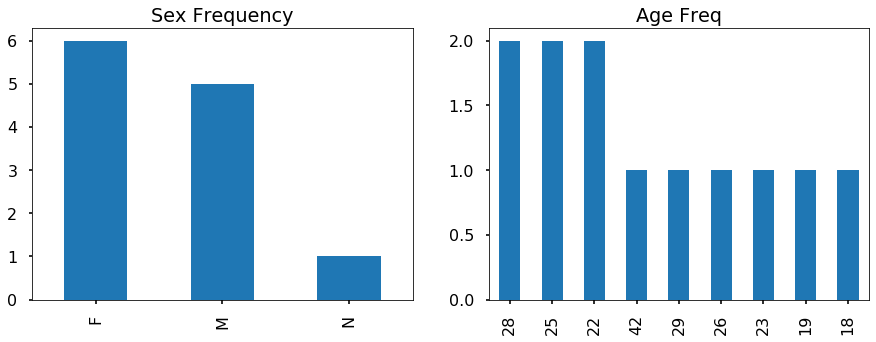

,What is your sex?,How old are you?
0,F,25
1,F,25
2,F,22
3,F,18
4,M,19
5,M,28
6,M,23
7,N,26
8,F,28
9,M,22


In [65]:
print('Age mean: ', np.mean(basics['How old are you?']))
basics['What is your sex?'].replace('A1','F',True)
basics['What is your sex?'].replace('A2','M',True)
basics['What is your sex?'].replace('A3','I',True)
basics['What is your sex?'].replace('A4','N',True)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
basics['What is your sex?'].value_counts().plot(ax=ax[0],kind='bar', title="Sex Frequency")
basics['How old are you?'].value_counts().plot(ax=ax[1],kind='bar', title="Age Freq")
plt.show()
basics

In [66]:
robot_interaction

,How familiar are you with computers?,Have you ever interacted with a robot before? [Never],Have you ever interacted with a robot before? [In an entertainment setting (i.e. drones)],"Have you ever interacted with a robot before? [In a commercial/utility setting (i.e. vacuums, industry)]",Have you ever interacted with a robot before? [At work (i.e. robotics research)],Do you like robots?
0,2,NaN,NaN,Y,NaN,A1
1,4,Y,NaN,NaN,NaN,A3
2,5,NaN,Y,NaN,NaN,A1
3,2,Y,NaN,NaN,NaN,A1
4,3,NaN,Y,Y,NaN,A1
5,4,Y,NaN,NaN,NaN,A1
6,5,NaN,Y,NaN,NaN,A3
7,5,NaN,NaN,Y,NaN,A1
8,5,NaN,NaN,NaN,Y,A1
9,4,Y,NaN,NaN,NaN,A1


In [67]:
godspeed.describe()

,"Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Fake – Natural]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Machinelike – Humanlike]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unconscious – Conscious]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Artificial – Lifelike]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Moving rigidly – Moving elegantly]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Dead – Alive]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Stagnant – Lively]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Mechanical – Organic]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Inert – Interactive]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Apathetic – Responsive]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Dislike – Like]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unfriendly – Friendly]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unkind – Kind]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unpleasant – Pleasant]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Awful – Nice]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Incompetent – Competent]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Ignorant – Knowledgeable]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Irresponsible – Responsible]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unintelligent – Intelligent]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Foolish - Sensible]","Please rate the following attributes now for robot 732-B (left). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural. [Fake – Natural]","Please rate the following attributes now for robot 732-B (left). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural. [Machinelike – Humanlike]","Please rate the following attributes now for robot 732-B (left). For example, in the first row '1' 

In [68]:
risk_propensity

,Do you agree or disagree with the following statements? [Safety first],Do you agree or disagree with the following statements? [I do not take risks with my health],Do you agree or disagree with the following statements? [I prefer to avoid risks],Do you agree or disagree with the following statements? [I take risks regularly],Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]
0,3,5,5,3,4
1,4,4,4,4,3
2,3,1,2,3,4
3,1,1,1,3,1
4,5,4,5,5,6
5,3,2,5,3,3
6,1,2,4,4,4
7,2,1,6,7,3
8,2,3,2,3,3
9,4,4,3,3,3


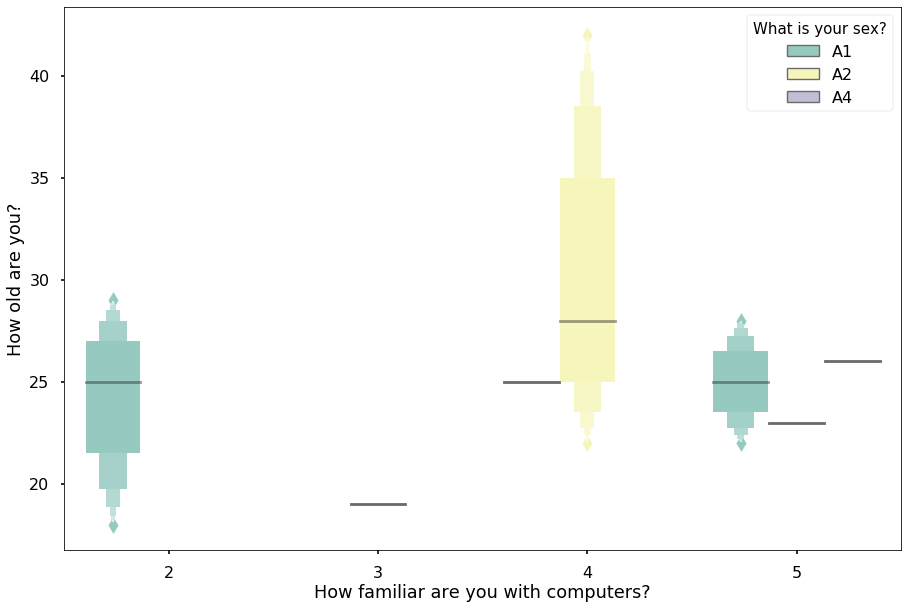

In [69]:
plt.figure(figsize=(15,10))
sns.boxenplot(df["How familiar are you with computers?"], df["How old are you?"] , hue=df["What is your sex?"], palette="Set3")
plt.show()

In [70]:
robot_interaction['fam_binary'] = 1
robot_interaction.loc[robot_interaction['Have you ever interacted with a robot before? [Never]'] == 'Yes', 'fam_binary'] = 0
robot_interaction

,How familiar are you with computers?,Have you ever interacted with a robot before? [Never],Have you ever interacted with a robot before? [In an entertainment setting (i.e. drones)],"Have you ever interacted with a robot before? [In a commercial/utility setting (i.e. vacuums, industry)]",Have you ever interacted with a robot before? [At work (i.e. robotics research)],Do you like robots?,fam_binary
0,2,NaN,NaN,Y,NaN,A1,1
1,4,Y,NaN,NaN,NaN,A3,1
2,5,NaN,Y,NaN,NaN,A1,1
3,2,Y,NaN,NaN,NaN,A1,1
4,3,NaN,Y,Y,NaN,A1,1
5,4,Y,NaN,NaN,NaN,A1,1
6,5,NaN,Y,NaN,NaN,A3,1
7,5,NaN,NaN,Y,NaN,A1,1
8,5,NaN,NaN,NaN,Y,A1,1
9,4,Y,NaN,NaN,NaN,A1,1


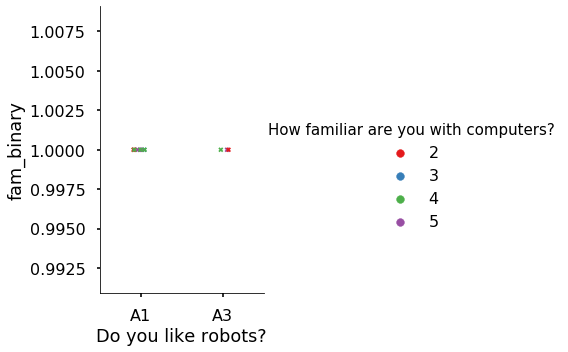

In [71]:
sns.catplot(x='Do you like robots?', y= "fam_binary", hue='How familiar are you with computers?', data=robot_interaction, palette="Set1", marker='X', kind="strip")
plt.show()

In [72]:
df2 = pd.DataFrame({'id': [1,2,3,4,5,6,7,8], 
                  's2_wrt_nvc': [-1,0,0,0,2,-2,2,-7]})
df2.describe()

,id,s2_wrt_nvc
count,8.00000,8.000000
mean,4.50000,-0.750000
std,2.44949,2.866058
min,1.00000,-7.000000
25%,2.75000,-1.250000
50%,4.50000,0.000000
75%,6.25000,0.500000
max,8.00000,2.000000


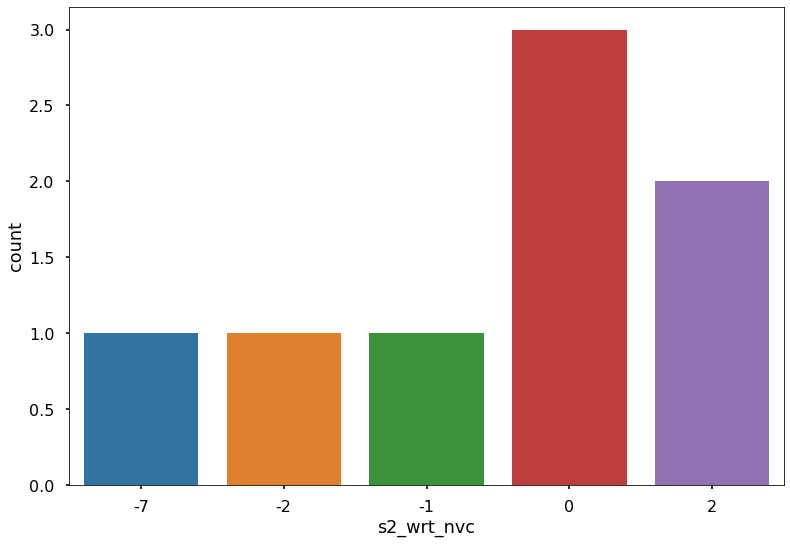

In [73]:
sns.countplot(x="s2_wrt_nvc", data=df2)
plt.show()

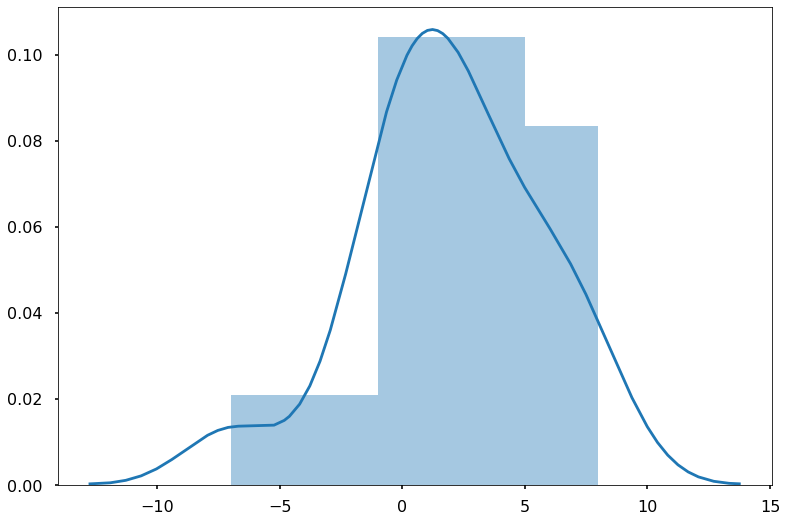

In [74]:
sns.distplot(df2)
plt.show()

In [75]:
df3 = pd.DataFrame({'id': [1,2,3,4,5,6,7,8], 
                    's0A': [0,1,2,2,1,1,2,1],
                    's0B' :[1,1,2,2,2,1,2,1],
                    's1A': [1,2,1,0,3,0,1,4],
                    's1B': [1,2,2,2,2,0,3,0],
                    's2A': [3,2,3,2,1,1,2,0],
                    's2B': [2,2,3,2,3,3,4,7],
                    's3A': [3,0,4,3,4,0,4,3],
                    's3B': [3,3,3,3,3,7,3,2],
                    's4A': [3,4,4,2,2,0,0,3],
                    's4B': [3,2,3,2,5,7,7,3],
                    'AB':['B','A','B','A','B','A','B','A']})
df3

,id,s0A,s0B,s1A,s1B,s2A,s2B,s3A,s3B,s4A,s4B,AB
0,1,0,1,1,1,3,2,3,3,3,3,B
1,2,1,1,2,2,2,2,0,3,4,2,A
2,3,2,2,1,2,3,3,4,3,4,3,B
3,4,2,2,0,2,2,2,3,3,2,2,A
4,5,1,2,3,2,1,3,4,3,2,5,B
5,6,1,1,0,0,1,3,0,7,0,7,A
6,7,2,2,1,3,2,4,4,3,0,7,B
7,8,1,1,4,0,0,7,3,2,3,3,A


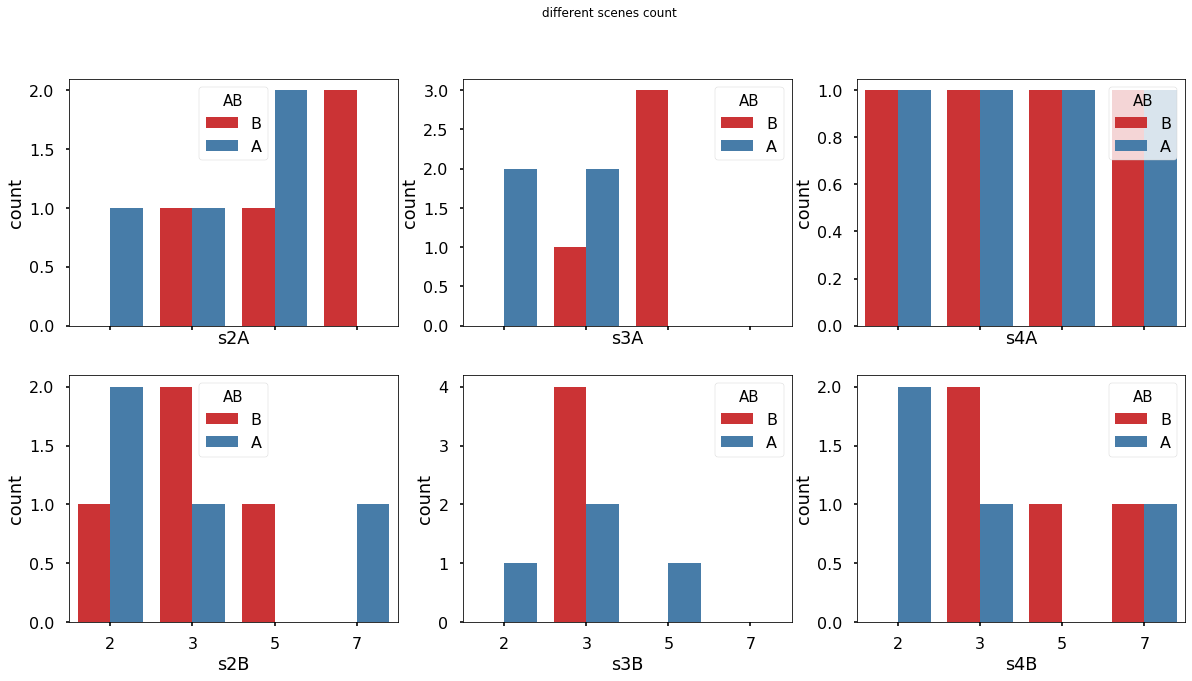

In [76]:
#sns.pairplot(hue='AB', data=df3, palette="Set1")
#plt.show()
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10),sharex=True)
fig.suptitle('different scenes count')
#fig.tight_layout()
sns.countplot(x='s2A', data=df3, ax=axs[0,0], hue='AB', palette="Set1")
sns.countplot(x='s2B', data=df3, ax=axs[1,0], hue='AB', palette="Set1")
sns.countplot(x='s3A', data=df3, ax=axs[0,1], hue='AB', palette="Set1")
sns.countplot(x='s3B', data=df3, ax=axs[1,1], hue='AB', palette="Set1")
sns.countplot(x='s4A', data=df3, ax=axs[0,2], hue='AB', palette="Set1")
sns.countplot(x='s4B', data=df3, ax=axs[1,2], hue='AB', palette="Set1")

plt.show()

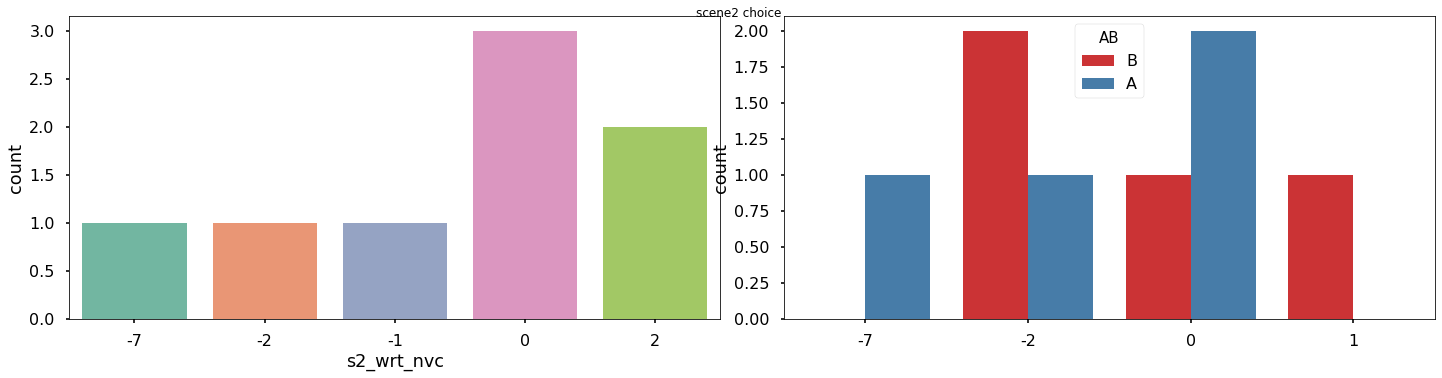

In [77]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('scene2 choice')
fig.tight_layout()
sns.countplot(x=df2['s2_wrt_nvc'], ax=axs[0], palette='Set2')
sns.countplot(df3['s2A']-df3['s2B'], ax=axs[1], hue=df3['AB'], palette='Set1')
plt.show()

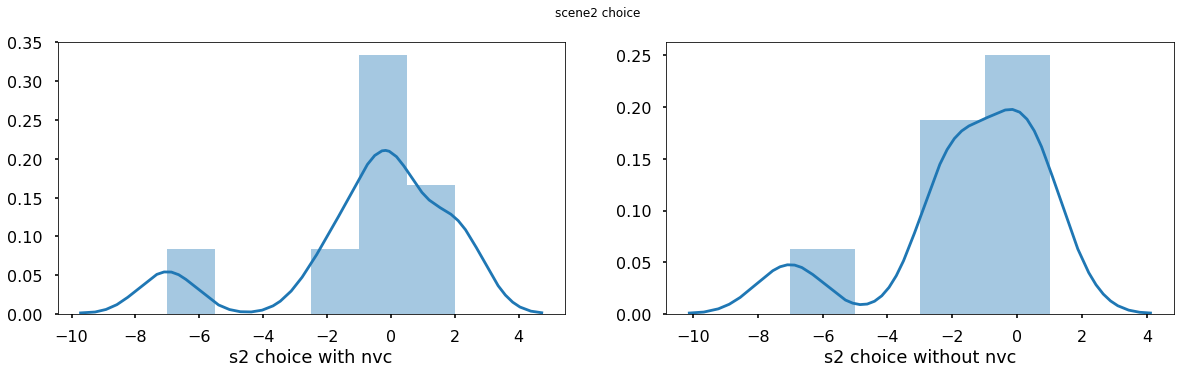

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('scene2 choice')
sns.distplot(df2['s2_wrt_nvc'], ax=axs[0], axlabel="s2 choice with nvc")
sns.distplot(df3['s2A']-df3['s2B'], ax=axs[1], axlabel="s2 choice without nvc")
plt.show()

                           Scene 2 choice categorized


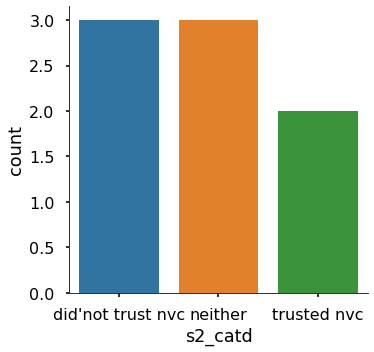

In [79]:
#df2['s2_wrt_nvc']
print("                           Scene 2 choice categorized")
df2['s2_catd'] = "neither"
df2.loc[df2['s2_wrt_nvc'] > 0, 's2_catd'] = "trusted nvc"
df2.loc[df2['s2_wrt_nvc'] < 0, 's2_catd'] = "did'not trust nvc"
sns.catplot(data=df2, x = 's2_catd',  kind="count")
plt.show()

No idea what this is


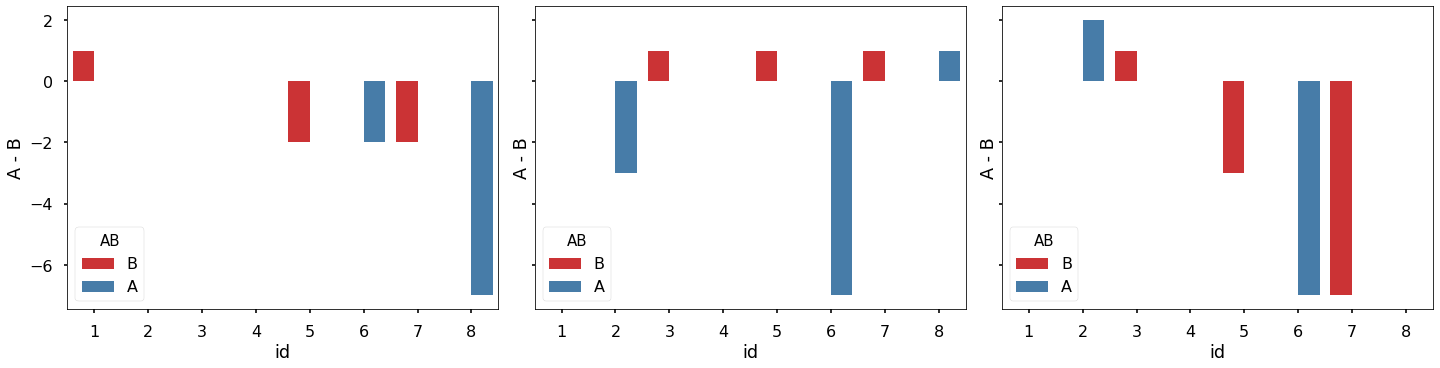

In [80]:
print('No idea what this is')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharey=True)
fig.tight_layout()
axs[0].set_xlabel("participant number")
axs[0].set_ylabel("A - B")
sns.barplot(x=df3['id'], y=df3['s2A']-df3['s2B'], ax=axs[0], hue=df3['AB'], palette="Set1")
axs[1].set_xlabel("participant number")
axs[1].set_ylabel("A - B")
sns.barplot(x=df3['id'], y=df3['s3A']-df3['s3B'], ax=axs[1], hue=df3['AB'], palette="Set1")
axs[2].set_xlabel("participant number")
axs[2].set_ylabel("A - B")
sns.barplot(x=df3['id'], y=df3['s4A']-df3['s4B'], ax=axs[2], hue=df3['AB'], palette="Set1")
plt.show()